## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [383]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [384]:
# Opening JSON file 
import os
f = open(os.getcwd()+'\complaints-2021-05-14_08_16.json')
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [385]:
# Inspect the dataframe to understand the given data.
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [386]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [387]:
#Assign new column names
df.rename(columns= lambda x: x.strip('_'), inplace=True)

In [388]:
df.head()

,index,type,id,score,source.tags,source.zip_code,source.complaint_id,source.issue,source.date_received,source.state,...,source.company_response,source.company,source.submitted_via,source.date_sent_to_company,source.company_public_response,source.sub_product,source.timely,source.complaint_what_happened,source.sub_issue,source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [389]:
df.rename(columns= lambda x: x.split('.')[1] if len(x.split('.'))>1 else x, inplace=True)

In [390]:
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [391]:
df.shape

(78313, 22)

In [392]:
df[df.complaint_what_happened == ''].shape

(57241, 22)

In [393]:
#Assign nan in place of blanks in the complaints column
df.complaint_what_happened.replace(to_replace='', value=np.nan, inplace=True)

In [394]:
#Remove all rows where complaints column is nan
df.dropna(subset=['complaint_what_happened'], inplace=True)

In [395]:
df.shape

(21072, 22)

In [396]:
df.complaint_what_happened.iloc[0]

'Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.'

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [397]:
# Write your function here to clean the text and remove all the unnecessary elements.
def text_cleanse(text):
    text = text.lower()                           # Make the text lowercase
    text = re.sub(r'\[\s*\w*\s*\]', "", text)     # Remove text in square brackets
    text = re.sub(r'[^\w\s]', "", text)           # Remove punctuation
    text = re.sub(r'\S*\d\S*', "", text)          # Remove words containing numbers
    text = re.sub(r'\n', "", text)                # Remove New Line character
    return text

In [398]:
df1 = pd.DataFrame(df['complaint_what_happened'].apply(text_cleanse))

In [399]:
df1.complaint_what_happened.iloc[0]

'good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services in  i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account  xxxx xxxx xxxx xxxx thanks in advance for your help'

In [400]:
#Write your function to Lemmatize the texts
def lemmmatize_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

In [401]:
df1['lemmatized_complaints'] = df1['complaint_what_happened'].apply(lemmmatize_text)

In [402]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = df1[['complaint_what_happened', 'lemmatized_complaints']]

In [403]:
df_clean

,complaint_what_happened,lemmatized_complaints
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt I have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thank in advance for your help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards the ticket if I apply for a reward card I put in my information for the offer and within less than a minute be notify via the screen that a decision could not be make I immediately contact xxxx and be refer to chase bank I then immediately contact chase bank within no more than of get the notification on the screen and I be tell by the chase representative I speak with that my application be deny but she could not state why I ask for 

In [404]:
df_clean.lemmatized_complaints.iloc[0]

'good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service in   I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt I have a right to know this information as a consumer chase account   xxxx xxxx xxxx xxxx thank in advance for your help'

In [405]:
#Write your function to extract the POS tags 
from textblob import TextBlob
import nltk
nltk.download('averaged_perceptron_tagger')

def pos_tag(text):
    blob = TextBlob(text)
    return ' '.join([word for (word,tag) in blob.tags if tag == "NN"])

df_clean["complaint_POS_removed"] =  df_clean['lemmatized_complaints'].apply(pos_tag)#this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\krish\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [406]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt I have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,card agent upgrade date agent information order account change date xxxxxxxx consent xxxx recording agent
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards the ticket if I apply for a reward card I put in my information for the off

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




<Figure size 720x432 with 0 Axes>

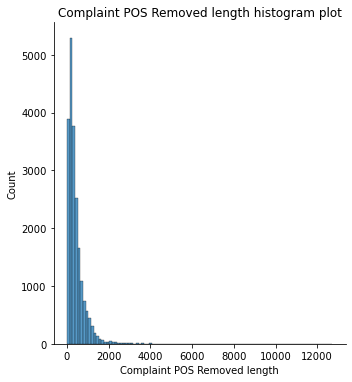

In [407]:
# Write your code here to visualise the data according to the 'Complaint' character length
df_clean['complaint_POS_removed_len'] = df_clean['complaint_POS_removed'].astype(str).apply(len)

plt.figure(figsize=(10,6))
sns.displot(list(df_clean['complaint_POS_removed_len']), kind='hist', bins=100)
plt.title('Complaint POS Removed length histogram plot')
plt.xlabel('Complaint POS Removed length')
plt.ylabel('Count')
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

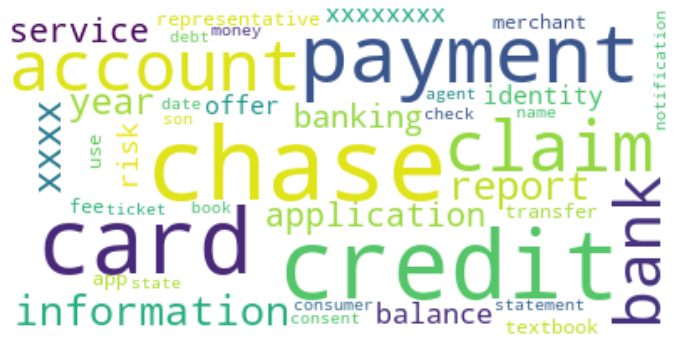

In [408]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
wordcloud = WordCloud(max_font_size=60, max_words=40, 
                      background_color="white", random_state=100, 
                      stopwords=stopwords).generate(str(df_clean.complaint_POS_removed))
plt.figure(figsize=[12,12])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [409]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

In [410]:
pd.set_option('display.max_colwidth', None)
df_clean.head()

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,complaint_POS_removed_len,Complaint_clean
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt I have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help,159,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,card agent upgrade date agent information order account change date xxxxxxxx consent xxxx recording agent,105,card agent upgrade date agent information order account change date xxxxxxxx consent xxxx recording agent
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant,74,card report application identity consent service credit identity applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in 

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [411]:
#Function to return the top 'n' words from corpus for a given 'n_gram_range'
def get_top_n_ngram(corpus, n_gram_range, n=None):
    vec = CountVectorizer(ngram_range=(n_gram_range, n_gram_range), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

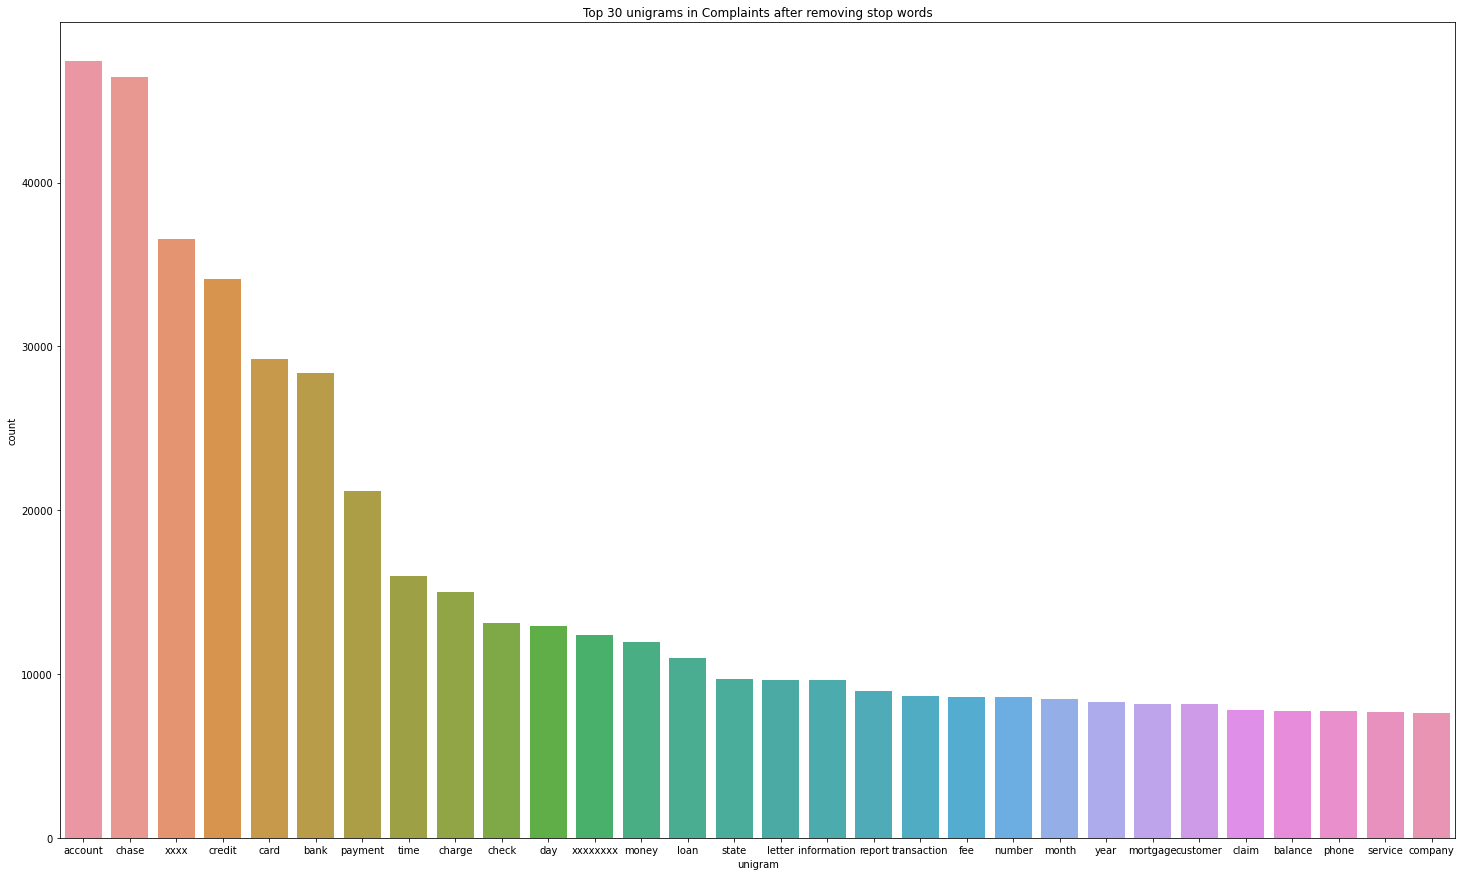

In [412]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
common_words = get_top_n_ngram(df_clean.Complaint_clean, 1, 30)
df_clean_unigram = pd.DataFrame(common_words, columns = ['unigram' , 'count'])
plt.figure(figsize=[25,15])
fig = sns.barplot(x=df_clean_unigram['unigram'], y=df_clean_unigram['count'])
plt.title('Top 30 unigrams in Complaints after removing stop words')
plt.show()

In [413]:
#Print the top 10 words in the unigram frequency
df_clean_unigram.head(10)

,unigram,count
0,account,47405
1,chase,46461
2,xxxx,36533
3,credit,34133
4,card,29246
5,bank,28385
6,payment,21155
7,time,16000
8,charge,14981
9,check,13131


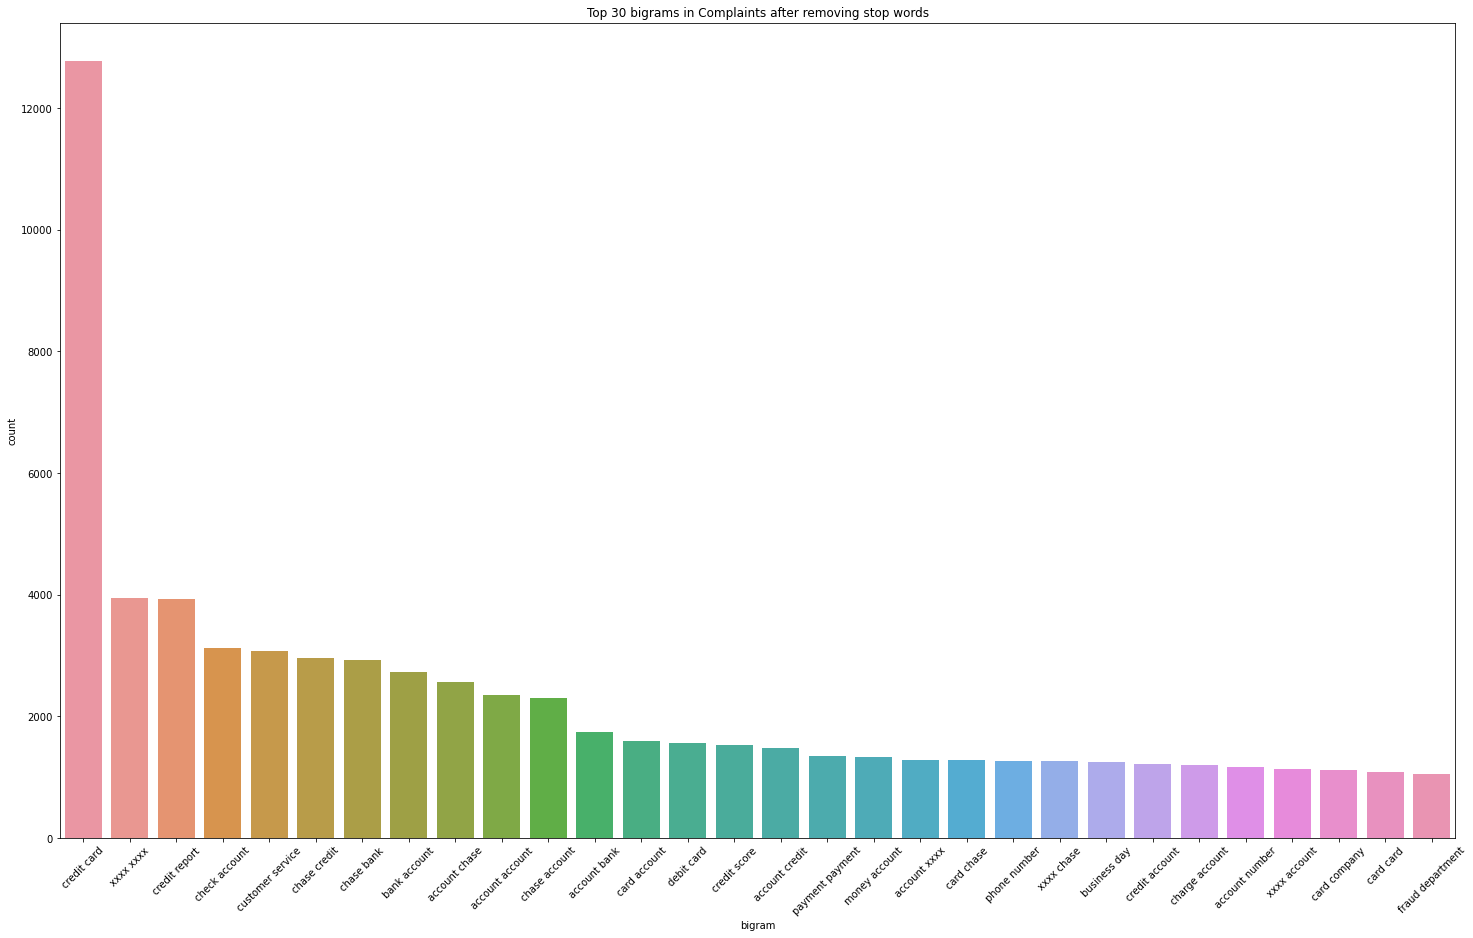

In [414]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
common_words = get_top_n_ngram(df_clean.Complaint_clean, 2, 30)
df_clean_bigram = pd.DataFrame(common_words, columns = ['bigram' , 'count'])
plt.figure(figsize=[25,15])
plt.xticks(rotation=45)
fig = sns.barplot(x=df_clean_bigram['bigram'], y=df_clean_bigram['count'])
plt.title('Top 30 bigrams in Complaints after removing stop words')
plt.show()

In [415]:
#Print the top 10 words in the bigram frequency
df_clean_bigram.head(10)

,bigram,count
0,credit card,12768
1,xxxx xxxx,3937
2,credit report,3924
3,check account,3126
4,customer service,3079
5,chase credit,2956
6,chase bank,2927
7,bank account,2722
8,account chase,2562
9,account account,2348


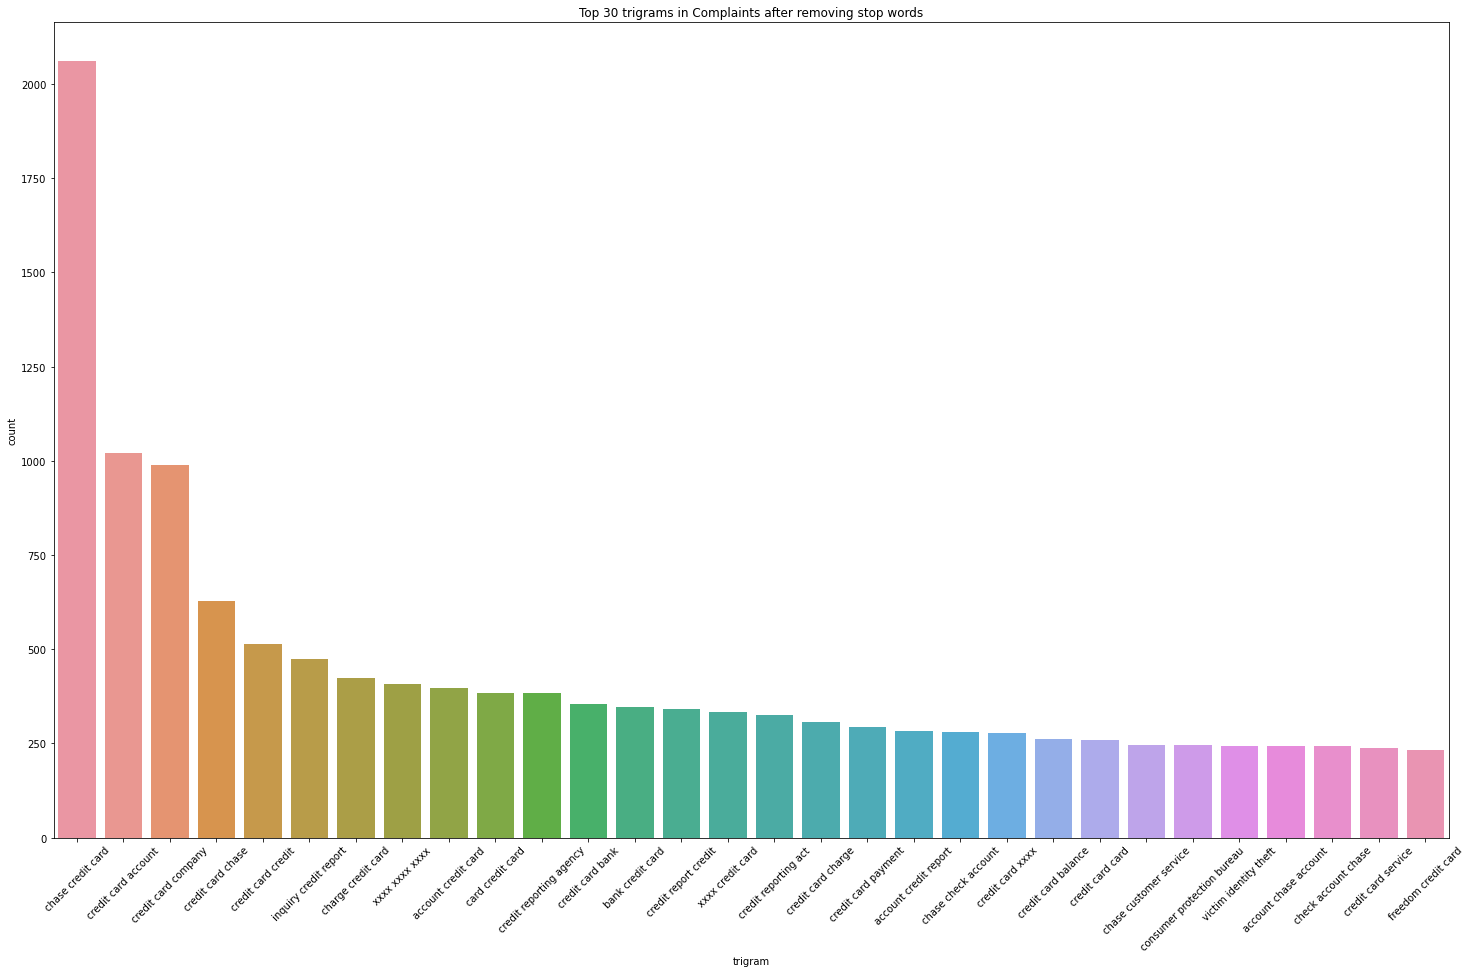

In [416]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
common_words = get_top_n_ngram(df_clean.Complaint_clean, 3, 30)
df_clean_trigram = pd.DataFrame(common_words, columns = ['trigram' , 'count'])
plt.figure(figsize=[25,15])
plt.xticks(rotation=45)
fig = sns.barplot(x=df_clean_trigram['trigram'], y=df_clean_trigram['count'])
plt.title('Top 30 trigrams in Complaints after removing stop words')
plt.show()

In [417]:
#Print the top 10 words in the trigram frequency
df_clean_trigram.head(10)

,trigram,count
0,chase credit card,2061
1,credit card account,1020
2,credit card company,989
3,credit card chase,629
4,credit card credit,514
5,inquiry credit report,475
6,charge credit card,423
7,xxxx xxxx xxxx,408
8,account credit card,396
9,card credit card,385


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [418]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [419]:
def remove_allXX(text):
  return re.sub('[x]{2,}',"",text)

df_clean['Complaint_clean'] = df_clean['Complaint_clean'].apply(remove_allXX)

In [420]:
#All masked texts has been removed
df_clean

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,complaint_POS_removed_len,Complaint_clean
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt I have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help,159,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,card agent upgrade date agent information order account change date xxxxxxxx consent xxxx recording agent,105,card agent upgrade date agent information order account change date consent recording agent
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant,74,card report application identity consent service credit identity applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on thi

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [421]:
#Write your code here to initialise the TfidfVectorizer 
tfidf = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [422]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['Complaint_clean'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [423]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [424]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40) #write your code here

In [425]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names())

C:\Users\krish\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



7360

In [426]:
H = nmf_model.components_  # Topic-term matrix

In [427]:
#Print the Top15 words for each of the topics
words = np.array(tfidf.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word{i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word1,Word2,Word3,Word4,Word5,Word6,Word7,Word8,Word9,Word10,Word11,Word12,Word13,Word14,Word15
Topic 1,account,check,bank,money,fund,chase,deposit,branch,day,number,business,transaction,claim,transfer,customer
Topic 2,credit,card,report,inquiry,chase,account,score,company,limit,information,debt,application,letter,balance,year
Topic 3,payment,balance,month,fee,statement,day,time,auto,date,pay,credit,account,chase,year,mortgage
Topic 4,charge,card,fee,transaction,dispute,chase,merchant,fraud,claim,purchase,service,time,refund,statement,company
Topic 5,loan,mortgage,home,modification,chase,property,year,letter,rate,time,document,bank,house,foreclosure,sale


In [428]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_results = nmf_model.transform(dtm)

In [429]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] = topic_results.argmax(axis=1)#write your code to assign topics to each rows.

In [430]:
df_clean.shape

(21072, 6)

In [431]:
df_clean.head()

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,complaint_POS_removed_len,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt I have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help,159,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help,4
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,card agent upgrade date agent information order account change date xxxxxxxx consent xxxx recording agent,105,card agent upgrade date agent information order account change date consent recording agent,1
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant,74,card report application identity consent service credit identity applicant,1
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my

In [432]:
#Print the first 5 Complaint for each of the Topics
df_clean.groupby('Topic').head(5)
df_clean.sort_values('Topic')

complaint_what_happened  \
30199                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [434]:
df_clean.shape

(21072, 6)

In [435]:
import copy
df_clean_final = copy.deepcopy(df_clean)

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [436]:
#Create the dictionary of Topic names and Topics
Topic_names = {0:"Bank account services", 1:"Credit card / Prepaid card", 2:"Others", 3:"Theft/Dispute reporting", 4:"Mortgages/loans"}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [437]:
df_clean

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,complaint_POS_removed_len,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt I have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help,159,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help,Mortgages/loans
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,card agent upgrade date agent information order account change date xxxxxxxx consent xxxx recording agent,105,card agent upgrade date agent information order account change date consent recording agent,Credit card / Prepaid card
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant,74,card report application identity consent service credit identity applicant,Credit card / Prepaid card
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase represen

In [438]:
df_clean_final

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,complaint_POS_removed_len,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt I have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help,159,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help,4
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,card agent upgrade date agent information order account change date xxxxxxxx consent xxxx recording agent,105,card agent upgrade date agent information order account change date consent recording agent,1
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant,74,card report application identity consent service credit identity applicant,1
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [439]:
#Create the dictionary again of Topic names and Topics
Topic_names = {"Bank account services":0, "Credit card / Prepaid card":1, "Others":2,
               "Theft/Dispute reporting":3, "Mortgages/loans":4}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [440]:
df_clean

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,complaint_POS_removed_len,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt I have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help,159,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help,4
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,card agent upgrade date agent information order account change date xxxxxxxx consent xxxx recording agent,105,card agent upgrade date agent information order account change date consent recording agent,1
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant,74,card report application identity consent service credit identity applicant,1
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my

In [441]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data= df_clean[['complaint_what_happened', 'Topic']]

In [442]:
training_data.shape

(21072, 2)

In [443]:
training_data

,complaint_what_happened,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help,4
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,1
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,1
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,1
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number xxxx claim number is xxxx with chase,0
...,...,...
78303,after being a chase card customer for well over a decade was offered multiple solicitations for acquiring new credit cards with chase all with bonus airline miles and hotel points was approved for all new cards with no annual fee for year after less than months with payment always paid as agreed chase closed all my cards one of my approved new cards was never activated but was sent to mechase has done harm to my credit has charged me an annual fee even though they cancelled my account failed to credit my points for both airlines and hotel failed to credit up to for xxxx enrollment and failed to credit airline charge as agreed upon,1
78309,on wednesday xxxxxxxx i called chas my xxxx xxxx visa credit card provider and asked how to make a claim under their purchase protection benefit on xxxxxxxx i purchased three high school textbooks for my xxxx year old daughter because she transferred to a new school all three books were damaged when a water bottle in her backpack broke the chase representative assured me the textbooks 

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [444]:
#Write your code to get the Vector count
vect = CountVectorizer()
X_train_cnt = vect.fit_transform(training_data['complaint_what_happened'])


#Write your code here to transform the word vector to tf-idf
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_cnt)

In [445]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve
from sklearn.linear_model import LogisticRegression

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [446]:
# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data['Topic'], test_size=0.25, random_state=42)

## Logistic Regression

In [447]:
# Write your code here to build any 3 models and evaluate them using the required metrics
logreg = LogisticRegression(random_state=42, solver='liblinear').fit(X_train, y_train)

In [448]:
# Getting the score of the base model
logreg.score(X_test, y_test)

0.9181852695520122

In [449]:
# Import pickle to save and load the model
import pickle

In [450]:
# Save Logistic Regression Model
pickle.dump(logreg, open("logreg_model.pk1", "wb"))

### Model Evaluation

In [451]:
# Load pickled model
logreg_model = pickle.load(open("logreg_model.pk1", "rb"))

In [452]:
# Make predictions on test data
y_pred = logreg_model.predict(X_test)

In [453]:
# Print Confusion Matrix
print(confusion_matrix(y_test, y_pred))

[[1242   20    3   22   15]
 [  24 1206    5   48    9]
 [  19   20  470   23   24]
 [  64   41    7 1071   20]
 [  23   24    7   13  848]]


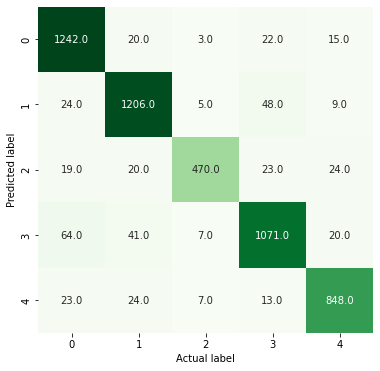

In [454]:
# Visualize Confusion Matrix with heatmap
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.heatmap(confusion_matrix(y_test, y_pred),
                 annot=True,
                 cbar=False,
                 cmap="Greens", fmt = '0.1f')
plt.xlabel("Actual label")
plt.ylabel("Predicted label")
plt.show()

In [455]:
Topicnames = ["Bank account services", "Credit card / Prepaid card", "Others", "Theft/Dispute reporting", "Mortgages/loans"]

In [456]:
# Print Classification Report
print(classification_report(y_test, y_pred, target_names = Topicnames))

                            precision    recall  f1-score   support

     Bank account services       0.91      0.95      0.93      1302
Credit card / Prepaid card       0.92      0.93      0.93      1292
                    Others       0.96      0.85      0.90       556
   Theft/Dispute reporting       0.91      0.89      0.90      1203
           Mortgages/loans       0.93      0.93      0.93       915

                  accuracy                           0.92      5268
                 macro avg       0.92      0.91      0.92      5268
              weighted avg       0.92      0.92      0.92      5268



#### Result
The overall accuracy of the Logistic Regression model is 92%.
Precision and Recall are 92% and 92% respectively which makes this is a very good model.

## Decision Tree Classifier

In [457]:
# Importing DecisionTreeClassifier from sklearn
from sklearn.tree import DecisionTreeClassifier

In [458]:
dt = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

In [459]:
# Getting the score of the base model
dt.score(X_test, y_test)

0.7744874715261959

In [460]:
# Save Logistic Regression Model
pickle.dump(dt, open("dt_model.pk1", "wb"))

### Model Evaluation

In [461]:
# Load pickled model
dt_model = pickle.load(open("dt_model.pk1", "rb"))

In [462]:
# Make predictions on test data
y_pred = dt_model.predict(X_test)

In [463]:
# Print Confusion Matrix
print(confusion_matrix(y_test, y_pred))

[[1040   59   36  121   46]
 [  72 1038   30  109   43]
 [  40   42  403   33   38]
 [ 130  125   31  858   59]
 [  52   30   45   47  741]]


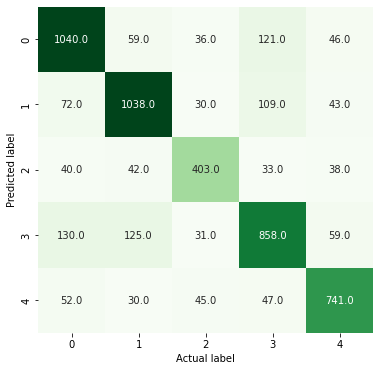

In [464]:
# Visualize Confusion Matrix with heatmap
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.heatmap(confusion_matrix(y_test, y_pred),
                 annot=True,
                 cbar=False,
                 cmap="Greens", fmt = '0.1f')
plt.xlabel("Actual label")
plt.ylabel("Predicted label")
plt.show()

In [465]:
# Print Classification Report
print(classification_report(y_test, y_pred, target_names = Topicnames))

                            precision    recall  f1-score   support

     Bank account services       0.78      0.80      0.79      1302
Credit card / Prepaid card       0.80      0.80      0.80      1292
                    Others       0.74      0.72      0.73       556
   Theft/Dispute reporting       0.73      0.71      0.72      1203
           Mortgages/loans       0.80      0.81      0.80       915

                  accuracy                           0.77      5268
                 macro avg       0.77      0.77      0.77      5268
              weighted avg       0.77      0.77      0.77      5268



#### Result
The overall accuracy of the  Decision Tree Classifier is 77%.
Precision and Recall are 77% and 77% respectively.

## Random Forest Classifier

In [466]:
# Importing Random Forest Classifier from sklearn
from sklearn.ensemble import RandomForestClassifier

In [467]:
rf = RandomForestClassifier(random_state=42).fit(X_train, y_train)

In [468]:
# Getting the score of the base model
rf.score(X_test, y_test)

0.8170083523158694

In [469]:
# Save Random Forest Model
pickle.dump(rf, open("rf_model.pk1", "wb"))

### Model Evaluation

In [470]:
# Load pickled model
rf_model = pickle.load(open("rf_model.pk1", "rb"))

In [471]:
# Make predictions on test data
y_pred = rf_model.predict(X_test)

In [472]:
# Print Confusion Matrix
print(confusion_matrix(y_test, y_pred))

[[1200   45    3   41   13]
 [  64 1107    2  101   18]
 [  78   85  240   67   86]
 [ 138   83    3  962   17]
 [  52   45    5   18  795]]


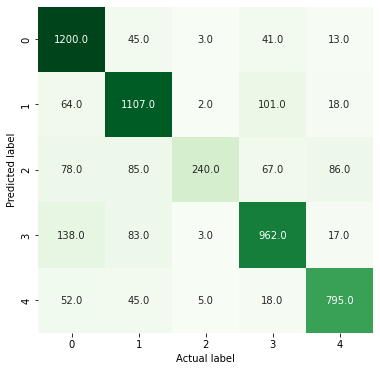

In [473]:
# Visualize Confusion Matrix with heatmap
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.heatmap(confusion_matrix(y_test, y_pred),
                 annot=True,
                 cbar=False,
                 cmap="Greens", fmt = '0.1f')
plt.xlabel("Actual label")
plt.ylabel("Predicted label")
plt.show()

In [474]:
# Print Classification Report
print(classification_report(y_test, y_pred, target_names = Topicnames))

                            precision    recall  f1-score   support

     Bank account services       0.78      0.92      0.85      1302
Credit card / Prepaid card       0.81      0.86      0.83      1292
                    Others       0.95      0.43      0.59       556
   Theft/Dispute reporting       0.81      0.80      0.80      1203
           Mortgages/loans       0.86      0.87      0.86       915

                  accuracy                           0.82      5268
                 macro avg       0.84      0.78      0.79      5268
              weighted avg       0.83      0.82      0.81      5268



#### Result
The overall accuracy of the Random Forest Classifier model is 82%.
Precision and Recall are 83% and 82% respectively.

## Multinomial Naive Bayes

In [475]:
from sklearn.naive_bayes import MultinomialNB

In [477]:
#Model fit on train and test data
mnb = MultinomialNB().fit(X_train, y_train)

In [478]:
# Getting the score of the base model
mnb.score(X_test, y_test)

0.718299164768413

In [479]:
# Save Random Forest Model
pickle.dump(mnb, open("mnb_model.pk1", "wb"))

### Model Evaluation

In [480]:
# Load pickled model
mnb_model = pickle.load(open("mnb_model.pk1", "rb"))

In [481]:
# Make predictions on test data
y_pred = mnb_model.predict(X_test)

In [482]:
# Print Confusion Matrix
print(confusion_matrix(y_test, y_pred))

[[1194   55    0   43   10]
 [ 165  975    0  144    8]
 [ 159  183    5  124   85]
 [ 216   51    0  932    4]
 [ 119   94    0   24  678]]


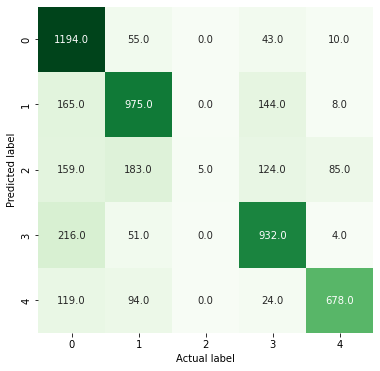

In [483]:
# Visualize Confusion Matrix with heatmap
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.heatmap(confusion_matrix(y_test, y_pred),
                 annot=True,
                 cbar=False,
                 cmap="Greens", fmt = '0.1f')
plt.xlabel("Actual label")
plt.ylabel("Predicted label")
plt.show()

In [484]:
# Print Classification Report
print(classification_report(y_test, y_pred, target_names = Topicnames))

                            precision    recall  f1-score   support

     Bank account services       0.64      0.92      0.76      1302
Credit card / Prepaid card       0.72      0.75      0.74      1292
                    Others       1.00      0.01      0.02       556
   Theft/Dispute reporting       0.74      0.77      0.75      1203
           Mortgages/loans       0.86      0.74      0.80       915

                  accuracy                           0.72      5268
                 macro avg       0.79      0.64      0.61      5268
              weighted avg       0.76      0.72      0.68      5268



#### Result
The overall accuracy of the Naive Bayes Classifier model is 72%.
Precision and Recall are 76% and 72% respectively.

## Overall Results
<br> Constructed supervised models (Logistic Regression, Decision Tree Classifier, Random Forest Classifier and Multinomial NB Classifier) to classify ticket/complaint to the relevant Topic("Bank account services", "Credit card / Prepaid card", "Others", "Theft/Dispute reporting", "Mortgages/loans"}. <br>
### <br>Logistic Regression
The overall accuracy of the Logistic Regression model is 92%.
Precision and Recall are 92% and 92% respectively.

### <br>Decision Tree
The overall accuracy of the  Decision Tree Classifier is 77%.
Precision and Recall are 77% and 77% respectively.

### <br>Random Forest
The overall accuracy of the Random Forest Classifier model is 82%.
Precision and Recall are 83% and 82% respectively.

### <br>Multinomial Naive Bayes
The overall accuracy of the Naive Bayes Classifier model is 72%.
Precision and Recall are 76% and 72% respectively.

### <br>Final Result
Based on the above results, Logistic Regression is the best model with an accuracy of 92% with Precision and Recall as 92% and 92% respectively